# Comments analysis

In [20]:
! pip install transformers torch
! pip install transformers datasets scikit-learn torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [79]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tqdm import tqdm
# from collections import Counter
# import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from transformers import TextClassificationPipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
# from sklearn.model_selection import train_test_split

In [6]:
df_all = pd.read_csv("data/data_clean/Comments_clean.csv")
df_all

,post_id,comment_text,comment_date,comment_user_id,channel_orientation,source_file,comment_language,text_transformed,date,views,forwards,channel_id,channel_name,source,bloc,period,post_age_at_comment
0,21390.0,"there will be no freedom, first trump is prepa...",2025-03-02 10:28:41,7.868621e+09,pro-ukrainian,data/ua/Comments_ds.csv,en,"there will be no freedom, first trump is prepa...",2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,38.129167
1,21390.0,i think us and ukraine could have a very good ...,2025-03-02 10:27:22,8.170125e+09,pro-ukrainian,data/ua/Comments_ds.csv,en,i think us and ukraine could have a very good ...,2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,38.107222
2,21390.0,ти антисеміт!!!ти гітлера підтримуєш???\nце як...,2025-03-02 10:10:15,7.868621e+09,pro-ukrainian,data/ua/Comments_ds.csv,uk,ти антисеміт!!!ти гітлера підтримуєш???\nце як...,2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,37.821944
3,21390.0,i think same goes for israel. lots of american...,2025-03-02 10:09:37,8.170125e+09,pro-ukrainian,data/ua/Comments_ds.csv,en,i think same goes for israel. lots of american...,2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,37.811389
4,21390.0,"тобто не посилати гроші в ізраїль, бо бідним а...",2025-03-02 10:08:18,7.868621e+09,pro-ukrainian,data/ua/Comments_ds.csv,uk,"тобто не посилати гроші в ізраїль, бо бідним а...",2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,37.789444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32885,93453.0,земли - россии 🇷🇺\nдолги - европе 🇪🇺\nденьги -...,2025-02-26 15:41:55,5.057871e+08,pro-russian,data/ru/Comments_re.csv,ru,земли - россии :Russia \nдолги - европе :Europ...,2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.069167
32886,93453.0,быть друзьями россии и быть с россией на равны...,2025-02-26 15:41:24,5.203758e+09,pro-russian,data/ru/Comments_re.csv,ru,быть друзьями россии и быть с россией на равны...,2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.060556
32887,93453.0,"50%? америкосы заберут 150,в этом сомневаться ...",2025-02-26 15:39:35,5.169864e+09,pro-russian,data/ru/Comments_re.csv,ru,"50%? америкосы заберут 150,в этом сомневаться ...",2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.030278
32888,93453.0,доня агент кремля,2025-02-26 15:38:56,2.033804e+09,pro-russian,data/ru/Comments_re.csv,ru,доня агент кремля,2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.019444


# Trying out russian and ukrianian sentiment models 

In [7]:
# Loading Russian sentiment model
model_name = "blanchefort/rubert-base-cased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Sampling Russian comments
sample_ru = df_all[
    (df_all["comment_language"] == "ru") & (df_all["bloc"] == "pro-russian")
    ]["text_transformed"].sample(20, random_state=1).tolist()


def predict_sentiment_ru(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions = torch.argmax(probs, dim=1)
    labels = ["negative", "neutral", "positive"]
    return [labels[i] for i in predictions]


ru_results = predict_sentiment_ru(sample_ru)
for text, label in zip(sample_ru, ru_results):
    print(f"{label.upper():<8} | {text}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


NEGATIVE | так можно говорить с президентом сша. один раз!
POSITIVE | трамп говорит "stupid president" не на зелю, а на байдена. прислушайтесь. трамп говорит: "мы дали вам благодаря тому тупому президенту..."
POSITIVE | его подпись под сделкой фикция.зелибоба никто.
POSITIVE | зеля как на оскаре, благодарю америку, маму, папу, кошку, мышку...:face_with_tears_of_joy :clown_face 
NEGATIVE | и потом кто-то на расширенной конференции будет руками разводить- ой нас опять объебали....
POSITIVE | обосрался - обтекай! а лучше застрелись.
NEGATIVE | ждём когда назовет нарколыгу террористом и диктатором. и приравняет к бен ладену или саддаму. и скажет, что те,  кто его поддерживают, будут считаться поддерживающие терроризм. и соответствующие санкции и прочие суды.
хотя, это надо было уже давно сказать, только нашим руководителям.
NEGATIVE | без твоих советов взрослые дяди разберутся
NEGATIVE | есть мнение насчет заявления трампа на прошедшей встрече с британцем, когда он отказался от своих слов,

In [8]:
# Trying for Ukrainian sentiment model
model_name_ua = "blanchefort/rubert-base-cased-sentiment"
tokenizer_ua = AutoTokenizer.from_pretrained(model_name_ua)
model_ua = AutoModelForSequenceClassification.from_pretrained(model_name_ua)


def predict_sentiment_ua(texts):
    inputs = tokenizer_ua(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model_ua(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions = torch.argmax(probs, dim=1)
    labels = ["negative", "neutral", "positive"]
    return [labels[i] for i in predictions]


# Sampling test
sample_ukr = df_all[
    (df_all["comment_language"] == "uk") & (df_all["bloc"] == "pro-ukrainian")
    ]["text_transformed"].sample(20, random_state=1).tolist()

ua_results = predict_sentiment_ua(sample_ukr)
for text, label in zip(sample_ukr, ua_results):
    print(f"{label.upper():<8} | {text}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


POSITIVE | немає ознак цього. це облуда. поки так.
POSITIVE | трамп боїться путіна
NEGATIVE | йо, є лінка на відос?
POSITIVE | занурись у своє болото і не смерди тут шавка путінська
POSITIVE | дуже приємно, а я думала твоя клікуха лиса голова.
NEGATIVE | подзвони пути і скажи щоб дрони розвертав вже зараз які летять
POSITIVE | зеленському сраку трампу треба бцло вилизувать? шоб трамп наступного ранку проснувся в іншому настрої і так само сказав як сьогодні??? то до чого б було те лизання??? а може завтра скаже шо зеленський красавчик бо зміг протистояти самому йому? у трампа 7 пʼятниць на неділю, не забувайте.
NEGATIVE | знову  на скандал  наривається
POSITIVE | підрило риже
POSITIVE | хоч хтось в цьому житті за довгий час сказав америкосам що вони самовпевненні гандони без совісті і честі!
POSITIVE | хз... тут треба було б юристами порадитись: можна було б і підписати, через пару років організувати звернення депутатів до кс, отримати висновок що угода суперечить конституції і послати 

In [9]:
# Loading public Ukrainian sentiment model
model_name_ua = "blanchefort/rubert-base-cased-sentiment"
tokenizer_ua = AutoTokenizer.from_pretrained(model_name_ua)
model_ua = AutoModelForSequenceClassification.from_pretrained(model_name_ua)


def predict_sentiment_ua(texts):
    inputs = tokenizer_ua(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model_ua(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions = torch.argmax(probs, dim=1)
    labels = ["negative", "neutral", "positive"]
    return [labels[i] for i in predictions]


# Sampling test
sample_ukr = df_all[
    (df_all["comment_language"] == "ru") & (df_all["bloc"] == "pro-ukrainian")
    ]["text_transformed"].sample(20, random_state=1).tolist()

ua_results = predict_sentiment_ua(sample_ukr)
for text, label in zip(sample_ukr, ua_results):
    print(f"{label.upper():<8} | {text}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


NEGATIVE | пососеш, ок?
POSITIVE | вибачаюсь, зря биканув
NEGATIVE | по тебе так точно, бот !)
NEGATIVE | ну как-то так дядя.
POSITIVE | по ходу-не понимают.
POSITIVE | ну так бойся сука в своем болоте! ті че думал в сказку попал и все обосрались,
POSITIVE | пиздец подкрался, в этот раз заметно
POSITIVE | хвора людина!
POSITIVE | китай росеи предупредил:index_pointing_up_selector ты думаешь путину позволят устроить апокалипсис? :woman_facepalming_selector ты идиот?
NEGATIVE | дудачок он
POSITIVE | сцить кому? мага-довбойоби навпаки, таким чином глузують
POSITIVE | просто позоиище
NEGATIVE | для украины очень плохо европа не потянет да им пофик они живут в мире я уверена что зеленский мог бы сесть за стол переговоров и спасти украину но не хочет правда до последнего украинца должны погибнуть понимают и хотят мира те у кого родные на фронте мы теряем каждый день людей територии разрушение территорий нужен мир что бы сохранить то что осталось
POSITIVE | європа так за нас , как и россия 
ч

# Trying lexicon-based sentiment analysis for Ukrainian 

In [10]:
# Loading the sentiment lexicon
lexicon_df = pd.read_csv("data/data_clean/sentiment_ua.csv", delimiter=";")
lexicon_df.columns = lexicon_df.columns.str.strip().str.replace('\ufeff', '')
print(lexicon_df.columns.tolist())


['word', 'pos_neg']


In [11]:
lexicon = dict(zip(lexicon_df["word"], lexicon_df["pos_neg"]))
# Simple sentiment scorer
def score_comment(text):
    score = 0
    words = text.lower().split()  # crude tokenization
    for word in words:
        score += lexicon.get(word, 0)
    return score


# Classifier based on score
def classify_sentiment(score):
    if score > 0:
        return "positive"  # 1
    elif score < 0:
        return "negative"  # -1
    else:
        return "neutral"  # 0


# Applying to Ukrainian comments only
ukr_comments = df_all[df_all["comment_language"] == "uk"].copy()
ukr_comments["ua_sentiment_score"] = ukr_comments["text_transformed"].apply(score_comment)
ukr_comments["ua_sentiment_label"] = ukr_comments["ua_sentiment_score"].apply(classify_sentiment)


In [12]:
print(ukr_comments[["text_transformed", "ua_sentiment_score", "ua_sentiment_label"]].sample(20, random_state=1))

                                        text_transformed  ua_sentiment_score  \
8294   я б не рекомендувала поки повзти в сторону\nпо...                  -2   
9375   політичний дрес-код:rolling_on_the_floor_laugh...                   0   
768    шановний отто . у єс єдина армія що має досвід...                   3   
16119  ні, дякую, ти не в трамваї і не в військоматі....                   0   
14480  як їм усім весело \nпоки по нашій країні летят...                  -2   
15728  а чо в нього єблет такий незадоволений сука ст...                   0   
3172   немає за що вибачатись.захід прогнив до дна,це...                   0   
837    як "президент" може "непублічно"протестувати ?...                   0   
16066  гіга-потужно, хочу ще:face_with_tears_of_joy :...                   0   
12271  зеленський лети в китай на зустріч з сін цен п...                   0   
14069              зеля тримайся ми з тобою:raised_fist                    0   
6235                              шо ти 

# Comparing two models:

In [13]:
# Sample 100 Ukrainian comments
ukr_sample = ukr_comments.sample(100, random_state=42).copy()

In [14]:
ukr_sample["ua_sentiment_score"] = ukr_sample["text_transformed"].apply(score_comment)
ukr_sample["lexicon_sentiment_label"] = ukr_sample["ua_sentiment_score"].apply(classify_sentiment)

In [15]:
ukr_sample["rubert_sentiment_label"] = predict_sentiment_ua(ukr_sample["text_transformed"].tolist())

In [16]:
# Count agreement and disagreements
ukr_sample["agree"] = ukr_sample["lexicon_sentiment_label"] == ukr_sample["rubert_sentiment_label"]
print("Agreement rate:", ukr_sample["agree"].mean())

# Confusion matrix-like view
comparison = ukr_sample.groupby(["lexicon_sentiment_label", "rubert_sentiment_label"]).size().unstack(fill_value=0)
print(comparison)

Agreement rate: 0.18
rubert_sentiment_label   negative  neutral  positive
lexicon_sentiment_label                             
negative                        2        0         7
neutral                        27        5        43
positive                        3        2        11


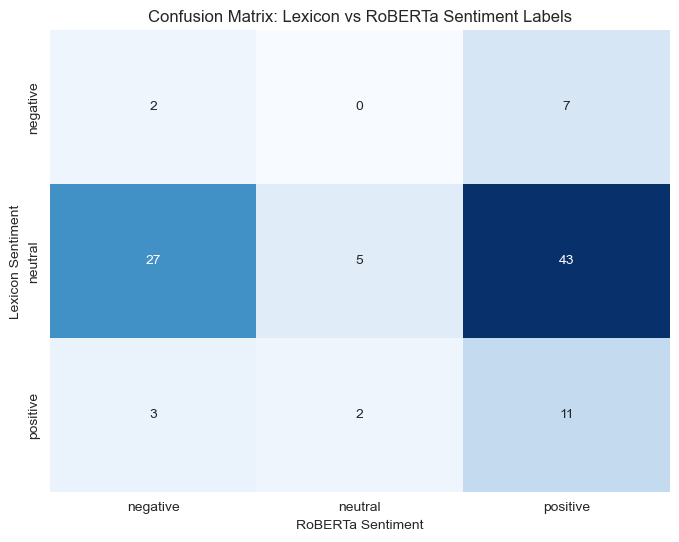

In [17]:
# Creating confusion matrix again (in case it's not in memory)
comparison = ukr_sample.groupby(
    ["lexicon_sentiment_label", "rubert_sentiment_label"]
).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(comparison, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix: Lexicon vs RoBERTa Sentiment Labels")
plt.xlabel("RoBERTa Sentiment")
plt.ylabel("Lexicon Sentiment")
plt.show()

In [18]:
# Filtering such mismatches
mismatch_df = ukr_sample[
    (ukr_sample["lexicon_sentiment_label"] == "neutral") &
    (ukr_sample["rubert_sentiment_label"] == "positive")
    ]

# Showing sample mismatches
for idx, row in mismatch_df.head(5).iterrows():
    print(f"\nTEXT: {row['text_transformed']}")
    print(f"LEXICON: {row['lexicon_sentiment_label']} | RoBERTa: {row['rubert_sentiment_label']}")


TEXT: китай теж не дурний, але трамп робить, що робить, а саме "купляє" собі союзників, або хоча б нейтралів у теоретичній війні.:man_shrugging_selector 
LEXICON: neutral | RoBERTa: positive

TEXT: я б не витримав й хвилини :pig_face 
LEXICON: neutral | RoBERTa: positive

TEXT: а може це треба зробити до путіна? таке враження що це українці напали на рф. :pouting_face 
LEXICON: neutral | RoBERTa: positive

TEXT: сталін костюми не носив, наприклад
LEXICON: neutral | RoBERTa: positive

TEXT: мага буде теперь купляти візу до києва!!!! наступні перемовини в бучі !!!
LEXICON: neutral | RoBERTa: positive


In [ ]:
tqdm.pandas()

def predict_sentiment_ua(texts):
    inputs = tokenizer_ua(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    with torch.no_grad():
        outputs = model_ua(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predictions = torch.argmax(probs, dim=1)
    labels = ["negative", "neutral", "positive"]
    return [labels[i] for i in predictions]


def batch_predict_sentiment(texts, batch_size=100):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        preds = predict_sentiment_ua(batch)
        results.extend(preds)
    return results


# Ukrainian comments
ukr_comments = df_all[df_all["comment_language"] == "uk"].copy()
ukr_comments = ukr_comments.reset_index(drop=True)

# Applying RoBERTa model in batches
ukr_comments["rubert_sentiment_label"] = batch_predict_sentiment(
    ukr_comments["text_transformed"].tolist(), batch_size=100
)

# Russian comments
ru_comments = df_all[df_all["comment_language"] == "ru"].copy()
ru_comments = ru_comments.reset_index(drop=True)

ru_comments["rubert_sentiment_label"] = batch_predict_sentiment(
    ru_comments["text_transformed"].tolist(), batch_size=100
)

# Combining both back together if needed
df_roberta_labeled = pd.concat([ukr_comments, ru_comments], ignore_index=True)

# Save to file
df_roberta_labeled.to_csv("data_clean/comments_labeled_roberta.csv", index=False)

In order to compare how good the RoBERT model works, I am labeleing a sample on my own and checking with the model

df_roberta_labeled.to_excel("data_clean/comments_labeled_roberta.xlsx", index=False)

In [22]:
df_labeled = pd.read_csv("data/data_clean/comments_labeled_manual.csv")
df_labeled

,post_id,comment_text,comment_date,comment_user_id,channel_orientation,source_file,comment_language,text_transformed,date,views,forwards,channel_id,channel_name,source,bloc,period,post_age_at_comment,rubert_sentiment_label,manual_label
0,21390,ти антисеміт!!!ти гітлера підтримуєш???\nце як...,2025-03-02 10:10:15,7.868621e+09,pro-ukrainian,data/ua/Comments_ds.csv,uk,ти антисеміт!!!ти гітлера підтримуєш???\nце як...,2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,37.821944,positive,negative
1,21390,"тобто не посилати гроші в ізраїль, бо бідним а...",2025-03-02 10:08:18,7.868621e+09,pro-ukrainian,data/ua/Comments_ds.csv,uk,"тобто не посилати гроші в ізраїль, бо бідним а...",2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,37.789444,positive,negative
2,21390,"сторіс, рілс, шортс, тік-ток на шевроні",2025-03-02 00:34:14,5.951120e+08,pro-ukrainian,data/ua/Comments_ds.csv,uk,"сторіс, рілс, шортс, тік-ток на шевроні",2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,28.221667,negative,neutral
3,21390,іноземний легіон бригади монако,2025-03-02 00:33:00,5.951120e+08,pro-ukrainian,data/ua/Comments_ds.csv,uk,іноземний легіон бригади монако,2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,28.201111,positive,neutral
4,21390,треба ще монету з диваном\nв честь венса,2025-03-02 00:31:56,2.765382e+08,pro-ukrainian,data/ua/Comments_ds.csv,uk,треба ще монету з диваном\nв честь венса,2025-02-28 20:20:56,441866,1146,-1001469021333,DeepStateUA,ds,pro-ukrainian,post,28.183333,negative,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31515,93453,земли - россии 🇷🇺\nдолги - европе 🇪🇺\nденьги -...,2025-02-26 15:41:55,5.057871e+08,pro-russian,data/ru/Comments_re.csv,ru,земли - россии :Russia \nдолги - европе :Europ...,2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.069167,positive,NaN
31516,93453,быть друзьями россии и быть с россией на равны...,2025-02-26 15:41:24,5.203758e+09,pro-russian,data/ru/Comments_re.csv,ru,быть друзьями россии и быть с россией на равны...,2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.060556,positive,NaN
31517,93453,"50%? америкосы заберут 150,в этом сомневаться ...",2025-02-26 15:39:35,5.169864e+09,pro-russian,data/ru/Comments_re.csv,ru,"50%? америкосы заберут 150,в этом сомневаться ...",2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.030278,negative,NaN
31518,93453,доня агент кремля,2025-02-26 15:38:56,2.033804e+09,pro-russian,data/ru/Comments_re.csv,ru,доня агент кремля,2025-02-26 15:37:46,397626,1383,-1001260622817,readovkanews,re,pro-russian,pre,0.019444,negative,NaN


In [23]:
valid_labels = {"positive", "neutral", "negative"}

labeled_subset = df_labeled[
    df_labeled["manual_label"].isin(valid_labels) &
    df_labeled["text_transformed"].notna() &
    (df_labeled["text_transformed"].str.strip() != "")
].copy()

In [24]:
print("Unique manual labels:", df_labeled["manual_label"].unique())
print("Missing text rows:", df_labeled["text_transformed"].isna().sum())
print("Empty text rows:", (df_labeled["text_transformed"].str.strip() == "").sum())

Unique manual labels: ['negative' 'neutral' 'positive' nan]
Missing text rows: 0
Empty text rows: 0


In [25]:
confusion = labeled_subset.groupby(["manual_label", "rubert_sentiment_label"]).size().unstack(fill_value=0)
print(confusion)

rubert_sentiment_label  negative  neutral  positive
manual_label                                       
negative                     146       19       202
neutral                       53       29        72
positive                       7        7        64


RoBERTa is strongly biased toward "positive"
Here we can see 202 comments, which I labeled as negative, but RoBERTa called positive.

Even for neutral, it labeled 72 as positive.

Suggests the model tends to underestimate criticism, sarcasm, and subtle hostility — likely due to being trained on more standard corpora or Russian social media with different tone norms.

# Fine-tunig the Rubert model for my dataset:

In [26]:
# Forcing PyTorch to use CPU instead of MPS/GPU
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [27]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# Step 3: Apply label mapping
labeled_subset["label"] = labeled_subset["manual_label"].map(label2id).astype(int)

In [28]:
dataset = Dataset.from_pandas(labeled_subset[["text_transformed", "label"]])
dataset = dataset.rename_columns({"text_transformed": "text"})
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [29]:
 # Loading tockenizer
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [30]:
# Tokenizing
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=True,
        max_length=512
    )

tokenized = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [31]:
tokenized = tokenized.map(lambda batch: {"label": [int(label) for label in batch["label"]]}, batched=True)

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [32]:
print(tokenized["train"][0]["label"], type(tokenized["train"][0]["label"]))

0 <class 'int'>


In [33]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)
model.to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [34]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    no_cuda=True
)

/Applications/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [35]:
print(next(model.parameters()).device)

cpu


In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
)

In [59]:
trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=440, training_loss=0.6561759255149148, metrics={'train_runtime': 401.6843, 'train_samples_per_second': 8.763, 'train_steps_per_second': 1.095, 'total_flos': 25960593162240.0, 'train_loss': 0.6561759255149148, 'epoch': 4.0})

In [38]:
# Saving the model
trainer.save_model("models/rubert-sentiment-finetuned")
tokenizer.save_pretrained("models/rubert-sentiment-finetuned")

('rubert-sentiment-finetuned/tokenizer_config.json',
 'rubert-sentiment-finetuned/special_tokens_map.json',
 'rubert-sentiment-finetuned/vocab.txt',
 'rubert-sentiment-finetuned/added_tokens.json',
 'rubert-sentiment-finetuned/tokenizer.json')

In [39]:
trainer.evaluate()

{'eval_loss': 0.86458820104599,
 'eval_runtime': 1.4627,
 'eval_samples_per_second': 82.037,
 'eval_steps_per_second': 10.255,
 'epoch': 4.0}

In [60]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipeline("Це справжній успіх для нашої країни.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Applications/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'negative', 'score': 0.1617555320262909},
  {'label': 'neutral', 'score': 0.46368080377578735},
  {'label': 'positive', 'score': 0.37456363439559937}]]

In [61]:
 def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "f1_weighted": f1_score(labels, predictions, average="weighted"),
    }

In [62]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [63]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=3)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [64]:
texts = [
    "Це справжній успіх для нашої країни.",
    "Це ганьба!",
    "Нічого не сталося.",
]

results = pipeline(texts)
for text, prediction in zip(texts, results):
    print(f"{text} → {prediction[0]['label']} ({prediction[0]['score']:.2f})")

Це справжній успіх для нашої країни. → neutral (0.46)
Це ганьба! → positive (0.71)
Нічого не сталося. → negative (0.53)


In [65]:
# Splitting by class
neg = df_labeled[df_labeled["manual_label"] == "negative"]
neu = df_labeled[df_labeled["manual_label"] == "neutral"]
pos = df_labeled[df_labeled["manual_label"] == "positive"]

# Upsample minority classes
neu_upsampled = resample(neu, replace=True, n_samples=len(neg), random_state=42)
pos_upsampled = resample(pos, replace=True, n_samples=len(neg), random_state=42)

# Combining into balanced set
df_balanced = pd.concat([neg, neu_upsampled, pos_upsampled])

In [66]:
df_labeled["manual_label"].value_counts()

negative    367
neutral     154
positive     78
Name: manual_label, dtype: int64

In [67]:
# Separating by class
neg = df_labeled[df_labeled["manual_label"] == "negative"]
neu = df_labeled[df_labeled["manual_label"] == "neutral"]
pos = df_labeled[df_labeled["manual_label"] == "positive"]

# Getting the size of the largest class
max_size = max(len(neg), len(neu), len(pos))

# Upsampling each class to match max_size
neg_up = resample(neg, replace=True, n_samples=max_size, random_state=42)
neu_up = resample(neu, replace=True, n_samples=max_size, random_state=42)
pos_up = resample(pos, replace=True, n_samples=max_size, random_state=42)

# Combining into one DataFrame
df_balanced = pd.concat([neg_up, neu_up, pos_up]).sample(frac=1, random_state=42).reset_index(drop=True)

In [68]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

df_balanced["label"] = df_balanced["manual_label"].map(label2id).astype(int)

In [69]:
# Dropping missing/blank rows
df_balanced = df_balanced[df_balanced["text_transformed"].notna()]
df_balanced = df_balanced[df_balanced["text_transformed"].str.strip() != ""]

# Renaming and select only relevant columns
df_ready = df_balanced[["text_transformed", "label"]].rename(columns={"text_transformed": "text"})

# Converting to Hugging Face Dataset
dataset = Dataset.from_pandas(df_ready)

# Train-test split
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [70]:
 # Loading tockenizer
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [71]:
# Tokenizing
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=True,
        max_length=512
    )

tokenized = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [72]:
tokenized = tokenized.map(lambda batch: {"label": [int(label) for label in batch["label"]]}, batched=True)

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [73]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)
model.to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [80]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "f1_weighted": f1_score(labels, predictions, average="weighted"),
    }

In [81]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    no_cuda=True
)

/Applications/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [82]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [83]:
trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=440, training_loss=0.6662392356178978, metrics={'train_runtime': 384.0855, 'train_samples_per_second': 9.165, 'train_steps_per_second': 1.146, 'total_flos': 25960593162240.0, 'train_loss': 0.6662392356178978, 'epoch': 4.0})

In [84]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipeline("Це справжній успіх для нашої країни.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Applications/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'negative', 'score': 0.1572302281856537},
  {'label': 'neutral', 'score': 0.4842468500137329},
  {'label': 'positive', 'score': 0.3585229218006134}]]

In [85]:
results = trainer.evaluate()
print({k: v for k, v in results.items() if k in ["eval_loss","eval_accuracy","eval_f1_macro","eval_f1_weighted"]})

{'eval_loss': 0.6527784466743469, 'eval_accuracy': 0.746606334841629, 'eval_f1_macro': 0.7462703680021168, 'eval_f1_weighted': 0.7468782889935391}
